**Pixel Area and Voxel Volume**

Este notebook mostrará como calcular a área de cada pixel em uma imagem dicom, bem como calcular o volume de cada voxel em uma série dicom. Para este notebook, usaremos uma única tomografia computadorizada extraída do conjunto de dados OSIC Pulmonary Fibrosis Progression (https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/data).


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()
!conda install -c conda-forge gdcm
!pip install pydicom==2.0.0

from google.colab import drive
drive.mount('/content/drive')

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    

In [1]:
!find "drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/modules/" -name "*.py" -exec cp {} ./ \;

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import utils_pt2 as utils

**Building a Dataframe with Dicom Tags**

Nós baixamos uma única série dicom do conjunto de dados mencionado anteriormente, já que precisamos apenas de 1 série para mostrar como calcular o volume de voxel. Vamos usar as funções desenvolvidas no [notebook](https://github.com/vpaula07/HandlingSeries) para construir um dataframe contendo todas as informações das dicoms que queremos ler. Observe que desta vez estamos solicitando algumas novas tags dicom:

- **SpacingBetweenSlices:** indica a distância (em mm) entre duas fatias consecutivas. O sinal desta tag também indica a orientação das fatias. Para mais informações, [SpacingBetweenSlices;](https://dicom.innolitics.com/ciods/nm-image/nm-reconstruction/00180088)
- **SliceLocation:** indica a posição (em mm) da fatia no eixo alvo de acordo com um determinado ponto de referência. Para mais informações, [SliceLocation](https://dicom.innolitics.com/ciods/ct-image/image-plane/00201041);
- **PixelSpacing:** uma matriz que indica o tamanho em mm de cada pixel de cada imagem dicom para os eixos X e Y.

In [5]:
CT_FOLDER = 'drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/CT_example/'

dicom_fields = {    'SOPInstanceUID':{'mandatory':True},
                    'SeriesInstanceUID':{'mandatory':True},
                    'SeriesDescription':{'mandatory':False},
                    'StudyInstanceUID':{'mandatory':True},
                    'InstanceNumber':{'mandatory':True},
                    'AcessionNumber':{'mandatory':False},
                    'PatientID':{'mandatory':False},
                    'ImagePositionPatient':{'mandatory':False},
                    'SpacingBetweenSlices':{'mandatory':True},
                    'SliceLocation':{'mandatory':True},
                    'PixelSpacing':{'mandatory':True}
              }

df = utils.get_valid_files_in_folder(CT_FOLDER, dicom_fields)
df

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,InstanceNumber,AcessionNumber,PatientID,ImagePositionPatient,SpacingBetweenSlices,SliceLocation,PixelSpacing,path
0,2.25.7033898623331216204008040355501281628,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,110,Null,ID00426637202313170790466,"[-191, -29, -233.5]",0.7,-233.5,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
1,2.25.59334089098003413500140569971939430058,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,113,Null,ID00426637202313170790466,"[-191, -29, -231.399963]",0.7,-231.4,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
2,2.25.14116800125783133903949813430907794224,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,104,Null,ID00426637202313170790466,"[-191, -29, -237.700012]",0.7,-237.7,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
3,2.25.154736764155691641865532088656029791628,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,108,Null,ID00426637202313170790466,"[-191, -29, -234.899963]",0.7,-234.9,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
4,2.25.26707030128822347818928552886776376986,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,103,Null,ID00426637202313170790466,"[-191, -29, -238.399963]",0.7,-238.4,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
...,...,...,...,...,...,...,...,...,...,...,...,...
403,2.25.40637333630608002720335184373592348433,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,85,Null,ID00426637202313170790466,"[-191, -29, -251]",0.7,-251.0,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
404,2.25.157996238218972818303630887158270087263,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,97,Null,ID00426637202313170790466,"[-191, -29, -242.599976]",0.7,-242.6,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
405,2.25.156400200381670092227781145955489050065,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,93,Null,ID00426637202313170790466,"[-191, -29, -245.399963]",0.7,-245.4,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
406,2.25.80854309193435012952228968058645552105,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,90,Null,ID00426637202313170790466,"[-191, -29, -247.5]",0.7,-247.5,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...


Como mencionamos anteriormente, esta pasta contém apenas uma única série. Vamos apenas certificar isso verificando o número de séries no dataframe:

In [6]:
df.SeriesInstanceUID.unique()

array(['2.25.136509711882067274997145019838799802041'], dtype=object)

Vamos agora apenas dar uma olhada na série dentro da pasta. Para fazer isso, usaremos o mesmo código que usamos no notebook [anterior](https://github.com/vpaula07/HandlingSeries):

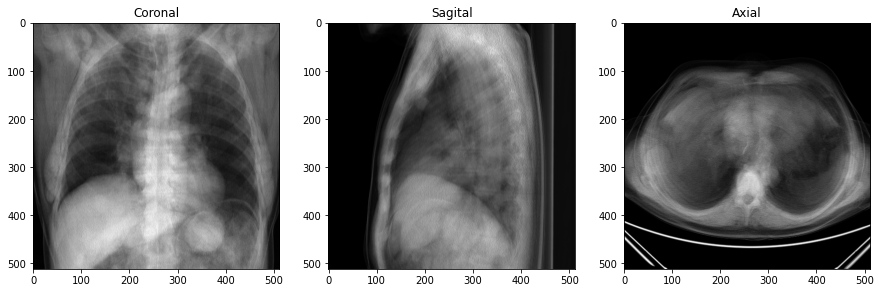

In [9]:
series = '2.25.136509711882067274997145019838799802041'
img3d = utils.get_series_arr(df, series, window_center=30, window_width=150)

img_ax = np.mean(img3d, axis=0)
img_cor = np.mean(img3d, axis=1)
img_sag = np.mean(img3d, axis=2)

img_cor = resize(img_cor, (512,512), preserve_range=True)
img_sag = resize(img_sag, (512,512), preserve_range=True)

f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(img_cor, cmap='gray')
axarr[0].title.set_text('Coronal')
axarr[1].imshow(img_sag, cmap='gray')
axarr[1].title.set_text('Sagital')
axarr[2].imshow(img_ax, cmap='gray')
axarr[2].title.set_text('Axial')

**Taking a Closer Look at the SpacingBetweenSlices, SliceLocation, and PixelSpacing Dicom Tags**

Agora que verificamos todas as informações básicas de nossa série, vejamos agora o que pretendíamos inicialmente: as novas tags dicom para volume de voxel. Um voxel é basicamente um pixel 3D, ou seja, um paralelepípedo atômico dentro de um paralelepípedo 3D maior representando toda a série (construído pelo empilhamento de todas as fatias). Saber o volume de um voxel é útil quando queremos calcular o volume de uma segmentação, por exemplo.

Podemos calcular o volume de um paralelepípedo multiplicando o comprimento de todas as suas 3 dimensões. Então, para calcular o volume de um voxel, precisamos da medida de todas as suas 3 dimensões. E é isso que essas novas tags dicom vão nos informar.

Antes de tudo, vamos ordenar nosso dataframe de acordo com a tag InstanceNumber, como fizemos anteriormente no notebook [anterior](https://github.com/vpaula07/HandlingSeries):

In [10]:
df = df.sort_values(by=['InstanceNumber'])
df

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,InstanceNumber,AcessionNumber,PatientID,ImagePositionPatient,SpacingBetweenSlices,SliceLocation,PixelSpacing,path
15,2.25.136077616400709387071091523878534687897,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,1,Null,ID00426637202313170790466,"[-191, -29, -309.799988]",0.7,-309.8,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
116,2.25.128178854142736037604902475358202221226,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,2,Null,ID00426637202313170790466,"[-191, -29, -309.099976]",0.7,-309.1,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
226,2.25.24724444926600754185794470584244735124,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,3,Null,ID00426637202313170790466,"[-191, -29, -308.399963]",0.7,-308.4,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
344,2.25.142200706345154115909860694415973640728,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,4,Null,ID00426637202313170790466,"[-191, -29, -307.700012]",0.7,-307.7,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
353,2.25.65956061419563560564767891630802763132,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,5,Null,ID00426637202313170790466,"[-191, -29, -307]",0.7,-307.0,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
...,...,...,...,...,...,...,...,...,...,...,...,...
340,2.25.126033227410626233124857395084919769090,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,404,Null,ID00426637202313170790466,"[-191, -29, -27.6999512]",0.7,-27.7,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
333,2.25.131696514796044090998380416761931522698,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,405,Null,ID00426637202313170790466,"[-191, -29, -26.999939]",0.7,-27.0,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
336,2.25.120889844046490217762449173683185440444,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,406,Null,ID00426637202313170790466,"[-191, -29, -26.2999878]",0.7,-26.3,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...
338,2.25.96196003328169671646999754241960890698,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,407,Null,ID00426637202313170790466,"[-191, -29, -25.5999756]",0.7,-25.6,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...


Da célula anterior, podemos notar alguns detalhes:

- A tag SliceLocation é um valor arredondado do eixo Z da tag ImagePositionPatient. Isso ocorre porque essa série é uma série axial, de modo que a posição de cada fatia varia ao longo do eixo Z;
- Se tomarmos a diferença entre o SliceLocation de dois slices consecutivos, obtemos o SpacingBetweenSlices. Observe aqui que, se SpacingBetweenSlices for positivo, o eixo Z do ImagePositionPatient está aumentando (considerando que as fatias são ordenadas de acordo com a tag InstanceNumber). Como vimos no notebook [anterior](https://github.com/vpaula07/HandlingSeries), isso significa que os cortes são invertidos, onde o primeiro corte está mais próximo dos pés e o corte final está mais próximo da cabeça. Portanto, o sinal de SpacingBetweenSlices é outra forma de saber se uma série está invertida ou não: um valor positivo de SpacingBetweenSlices indica que ela está invertida;

A dimensão de cada voxel nos eixos X e Y é dada pela tag dicom PixelSpacing: é um array com 2 valores, um especificando o comprimento do eixo X do voxel em mm e o outro para o eixo Y. Portanto, a área de cada pixel é obtida pela multiplicação desses 2 valores, resultando na área de pixel de cada imagem em mm2.

Quanto ao comprimento do eixo Z de cada voxel, este pode ser obtido pelo SpacingBetweenSlices. Mas apenas para ter certeza de que o SpacingBetweenSlices está correto (com dicoms, nunca sabemos....), você pode calcular a diferença entre slices manualmente. Na célula a seguir, calculamos a área do pixel e a diferença de fatia. Finalmente, calculamos o volume de voxel para cada arquivo dicom.

In [12]:
def get_pixel_area(pixel_spacing):
  return pixel_spacing[0] * pixel_spacing[1]

df['SliceDiff'] = df.groupby(['SeriesInstanceUID'])['SliceLocation'].diff().fillna(0)
df['SliceDiff'] = df.groupby(['SeriesInstanceUID'])['SliceDiff'].transform(max)
df['SliceDiff'] = df['SliceDiff'].apply(float)
df['PixelArea'] = df['PixelSpacing'].apply(get_pixel_area)
df['voxel_vol'] = df['PixelArea'] * df['SliceDiff']
df

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,InstanceNumber,AcessionNumber,PatientID,ImagePositionPatient,SpacingBetweenSlices,SliceLocation,PixelSpacing,path,SliceDiff,PixelArea,voxel_vol
15,2.25.136077616400709387071091523878534687897,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,1,Null,ID00426637202313170790466,"[-191, -29, -309.799988]",0.7,-309.8,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
116,2.25.128178854142736037604902475358202221226,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,2,Null,ID00426637202313170790466,"[-191, -29, -309.099976]",0.7,-309.1,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
226,2.25.24724444926600754185794470584244735124,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,3,Null,ID00426637202313170790466,"[-191, -29, -308.399963]",0.7,-308.4,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
344,2.25.142200706345154115909860694415973640728,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,4,Null,ID00426637202313170790466,"[-191, -29, -307.700012]",0.7,-307.7,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
353,2.25.65956061419563560564767891630802763132,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,5,Null,ID00426637202313170790466,"[-191, -29, -307]",0.7,-307.0,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,2.25.126033227410626233124857395084919769090,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,404,Null,ID00426637202313170790466,"[-191, -29, -27.6999512]",0.7,-27.7,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
333,2.25.131696514796044090998380416761931522698,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,405,Null,ID00426637202313170790466,"[-191, -29, -26.999939]",0.7,-27.0,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
336,2.25.120889844046490217762449173683185440444,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,406,Null,ID00426637202313170790466,"[-191, -29, -26.2999878]",0.7,-26.3,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621
338,2.25.96196003328169671646999754241960890698,2.25.136509711882067274997145019838799802041,Null,2.25.46683361475185465349755690410809772979,407,Null,ID00426637202313170790466,"[-191, -29, -25.5999756]",0.7,-25.6,"[0.71875, 0.71875]",drive/MyDrive/Curso IA para Medicina - Cientis...,0.7,0.516602,0.361621


**Regarding SliceThickness**

Em relação à espessura da fatia e a tag dicom SliceThickness: O SliceThickness indica a espessura de cada fatia em mm. Mas, às vezes, duas fatias consecutivas têm alguma sobreposição, ou seja, uma área que está presente em ambas as fatias. O SliceThickness não leva em conta essa sobreposição, mas o SliceDiff que calculamos na célula anterior sim (o SpacingBetweenSlices também parece levar em conta isso). Portanto, é por isso que não usamos o SliceThickness ao calcular o volume de voxel.